In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lasio
import xgboost as xgb
import scooby
import torch
import torch.nn as nn
import sklearn

from scipy.signal import filtfilt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import TensorDataset, DataLoader 
from torchsummary import summary
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error 
from sklearn.model_selection import train_test_split

# Pre-training

In [2]:
# ['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']

input_train = np.load('../../drive/Project/testing/wireline_attention/notebook/8_4_4_128_nooutlier/pretrain/input_train.npy')
input_valid = np.load('../../drive/Project/testing/wireline_attention/notebook/8_4_4_128_nooutlier/pretrain/input_valid.npy')

pred_train = np.load('../../drive/Project/testing/wireline_attention/notebook/8_4_4_128_nooutlier/pretrain/pred_train.npy')
pred_valid = np.load('../../drive/Project/testing/wireline_attention/notebook/8_4_4_128_nooutlier/pretrain/pred_valid.npy')

In [3]:
def plot_wirelines(data_plot):
    fig, ax = plt.subplots(figsize=(15,8))#Set up the plot axes
    ax1 = plt.subplot2grid((1,6), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,6), (0,1), rowspan=1, colspan = 1, sharey = ax1)
    ax3 = plt.subplot2grid((1,6), (0,2), rowspan=1, colspan = 1, sharey = ax1)
    ax4 = plt.subplot2grid((1,6), (0,3), rowspan=1, colspan = 1, sharey = ax1)
    ax5 = ax3.twiny() 

    #Twins the y-axis for the density track with the neutron track
    ax6 = plt.subplot2grid((1,6), (0,4), rowspan=1, colspan = 1, sharey = ax1)

    # As our curve scales will be detached from the top of the track,
    # this code adds the top border back in without dealing with splines
    ax10 = ax1.twiny()
    ax10.xaxis.set_visible(False)
    ax11 = ax2.twiny()
    ax11.xaxis.set_visible(False)
    ax12 = ax3.twiny()
    ax12.xaxis.set_visible(False)
    ax13 = ax4.twiny()
    ax13.xaxis.set_visible(False)
    ax14 = ax6.twiny()
    ax14.xaxis.set_visible(False)

    # Gamma Ray track
    ax1.plot("GR", "DEPTH_MD", data=data_plot, color = "green", linewidth = 0.5)
    ax1.set_xlabel("Gamma")
    ax1.xaxis.label.set_color("green")
    # ax1.set_xlim(0, 200)
    ax1.set_ylabel("Depth (m)")
    ax1.tick_params(axis='x', colors="green")
    ax1.spines["top"].set_edgecolor("green")
    ax1.title.set_color('green')
    # ax1.set_xticks([0, 50, 100, 150, 200])

    # Resistivity track
    ax2.plot("RDEP", "DEPTH_MD", data=data_plot, color = "red", linewidth = 0.5)
    ax2.set_xlabel("Resistivity - Deep")
    # ax2.set_xlim(0.2, 2000)
    ax2.xaxis.label.set_color("red")
    ax2.tick_params(axis='x', colors="red")
    ax2.spines["top"].set_edgecolor("red")
    # ax2.set_xticks([0.1, 1, 10, 100, 1000])
    # ax2.semilogx()

    # Density track
    ax3.plot("RHOB", "DEPTH_MD", data=data_plot, color = "red", linewidth = 0.5)
    ax3.set_xlabel("Density")
    # ax3.set_xlim(1.95, 2.95)
    ax3.xaxis.label.set_color("red")
    ax3.tick_params(axis='x', colors="red")
    ax3.spines["top"].set_edgecolor("red")
    # ax3.set_xticks([1.95, 2.45, 2.95])

    # Sonic track
    ax4.plot("DTC", "DEPTH_MD", data=data_plot, color = "purple", linewidth = 0.5)
    ax4.set_xlabel("Sonic - Compressional")
    # ax4.set_xlim(140, 40)
    ax4.xaxis.label.set_color("purple")
    ax4.tick_params(axis='x', colors="purple")
    ax4.spines["top"].set_edgecolor("purple")

    # Neutron track placed ontop of density track
    ax5.plot("NPHI", "DEPTH_MD", data=data_plot, color = "blue", linewidth = 0.5)
    ax5.set_xlabel('Neutron')
    ax5.xaxis.label.set_color("blue")
    # ax5.set_xlim(.5, 0)
    ax5.tick_params(axis='x', colors="blue")
    ax5.spines["top"].set_position(("axes", 1.1))
    ax5.spines["top"].set_visible(True)
    ax5.spines["top"].set_edgecolor("blue")
    # ax5.set_xticks([45,  15, -15])

    # Caliper track
    ax6.plot("CALI", "DEPTH_MD", data=data_plot, color = "black", linewidth = 0.5)
    ax6.set_xlabel("Caliper")
    # ax6.set_xlim(8, 10)
    ax6.xaxis.label.set_color("black")
    ax6.tick_params(axis='x', colors="black")
    ax6.spines["top"].set_edgecolor("black")
    # ax6.fill_betweenx(well_nan.index, 8.5, well["CALI"], facecolor='yellow')
    # ax6.set_xticks([6,  11, 16])

    # Common functions for setting up the plot can be extracted into
    # a for loop. This saves repeating code.
    for ax in [ax1, ax2, ax3, ax4, ax6]:
        # ax.set_ylim(4500, 3500)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))
        
    for ax in [ax2, ax3, ax4, ax6]:
        plt.setp(ax.get_yticklabels(), visible = False)
        
    plt.tight_layout()
    fig.subplots_adjust(wspace = 0.15)
    plt.show()

## Data dari lu

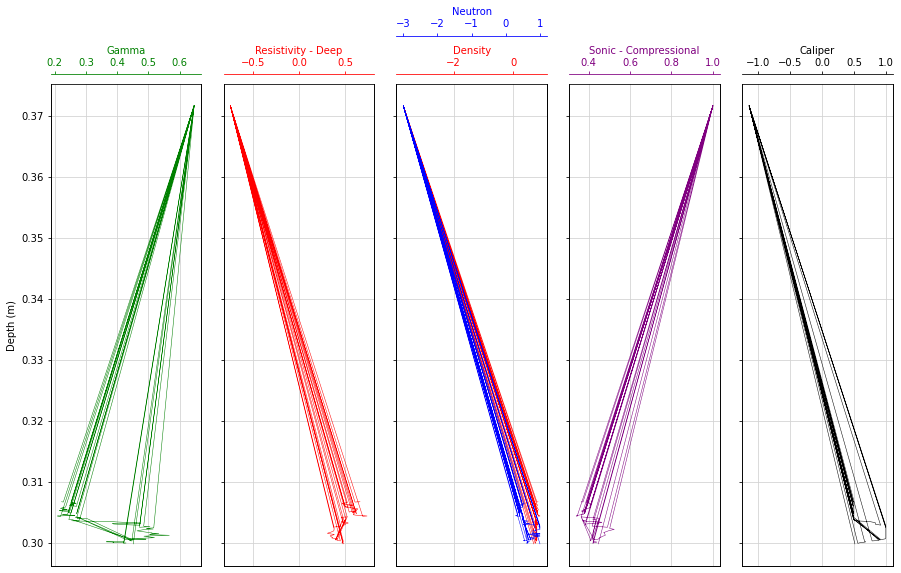

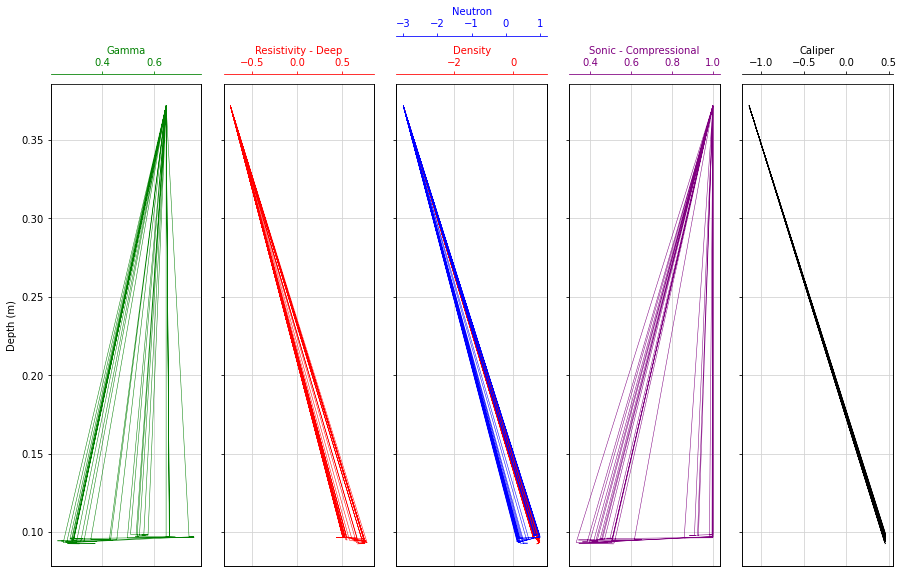

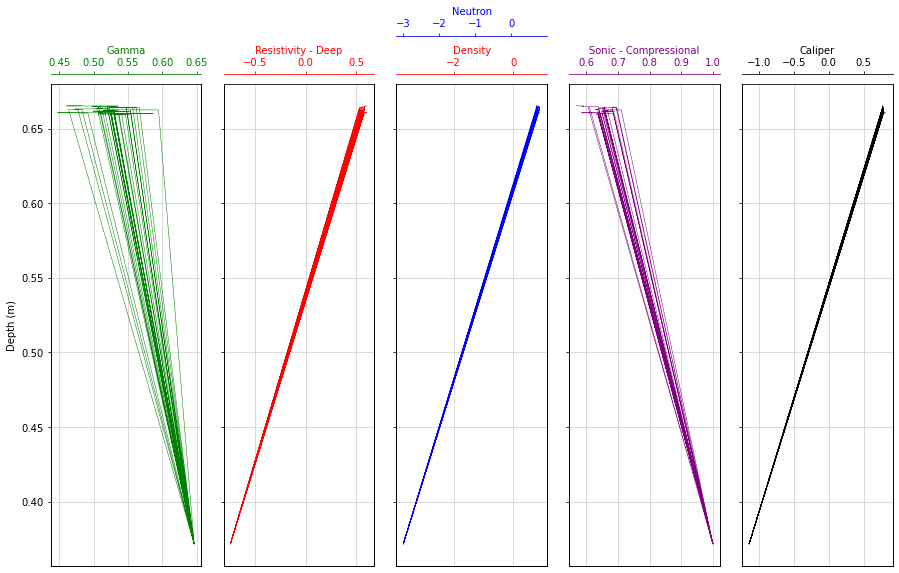

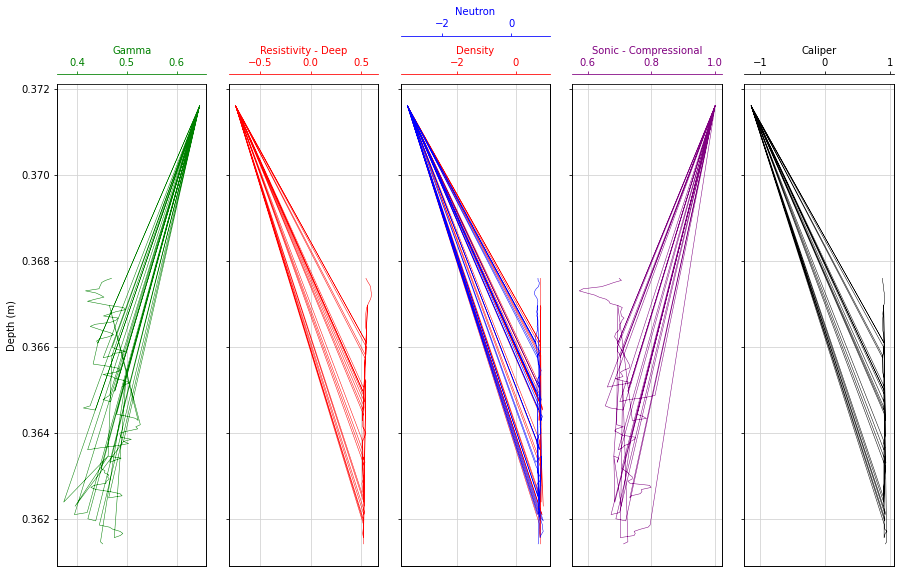

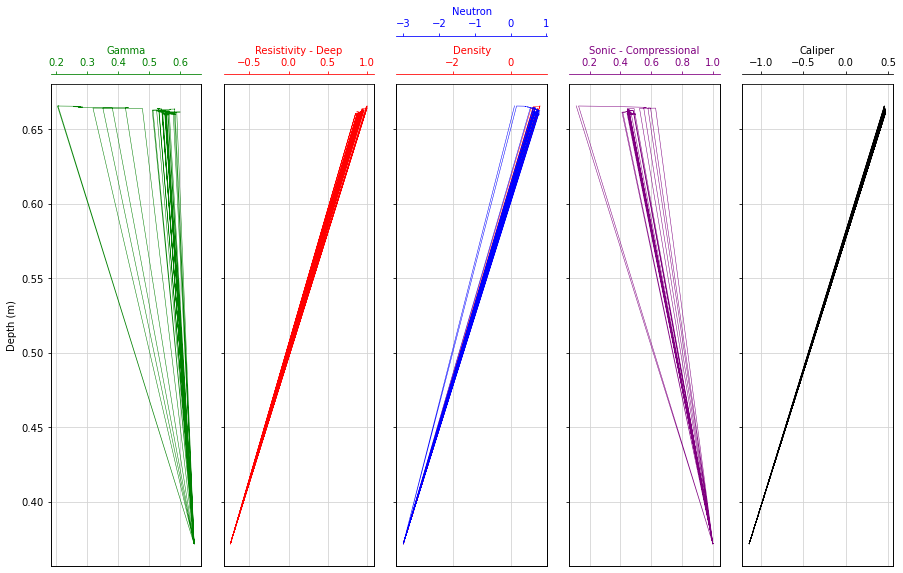

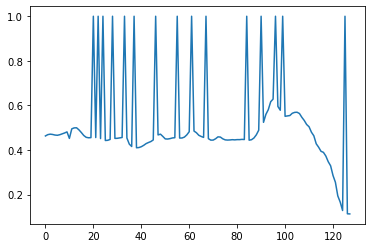

In [7]:
idx = 500

input_train_df = pd.DataFrame(input_train[idx], columns=['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC'])
pred_train_df = pd.DataFrame(pred_train[idx], columns=['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC'])

for i in range(len(input_train)):
    if i % 250 == 0:
        input_train_df = pd.DataFrame(input_train[i], columns=['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC'])
        plot_wirelines(input_train_df)

plt.plot(input_train_df['DTC'])

/home/taufikmh/miniconda3/envs/thesis-pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
/home/taufikmh/miniconda3/envs/thesis-pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


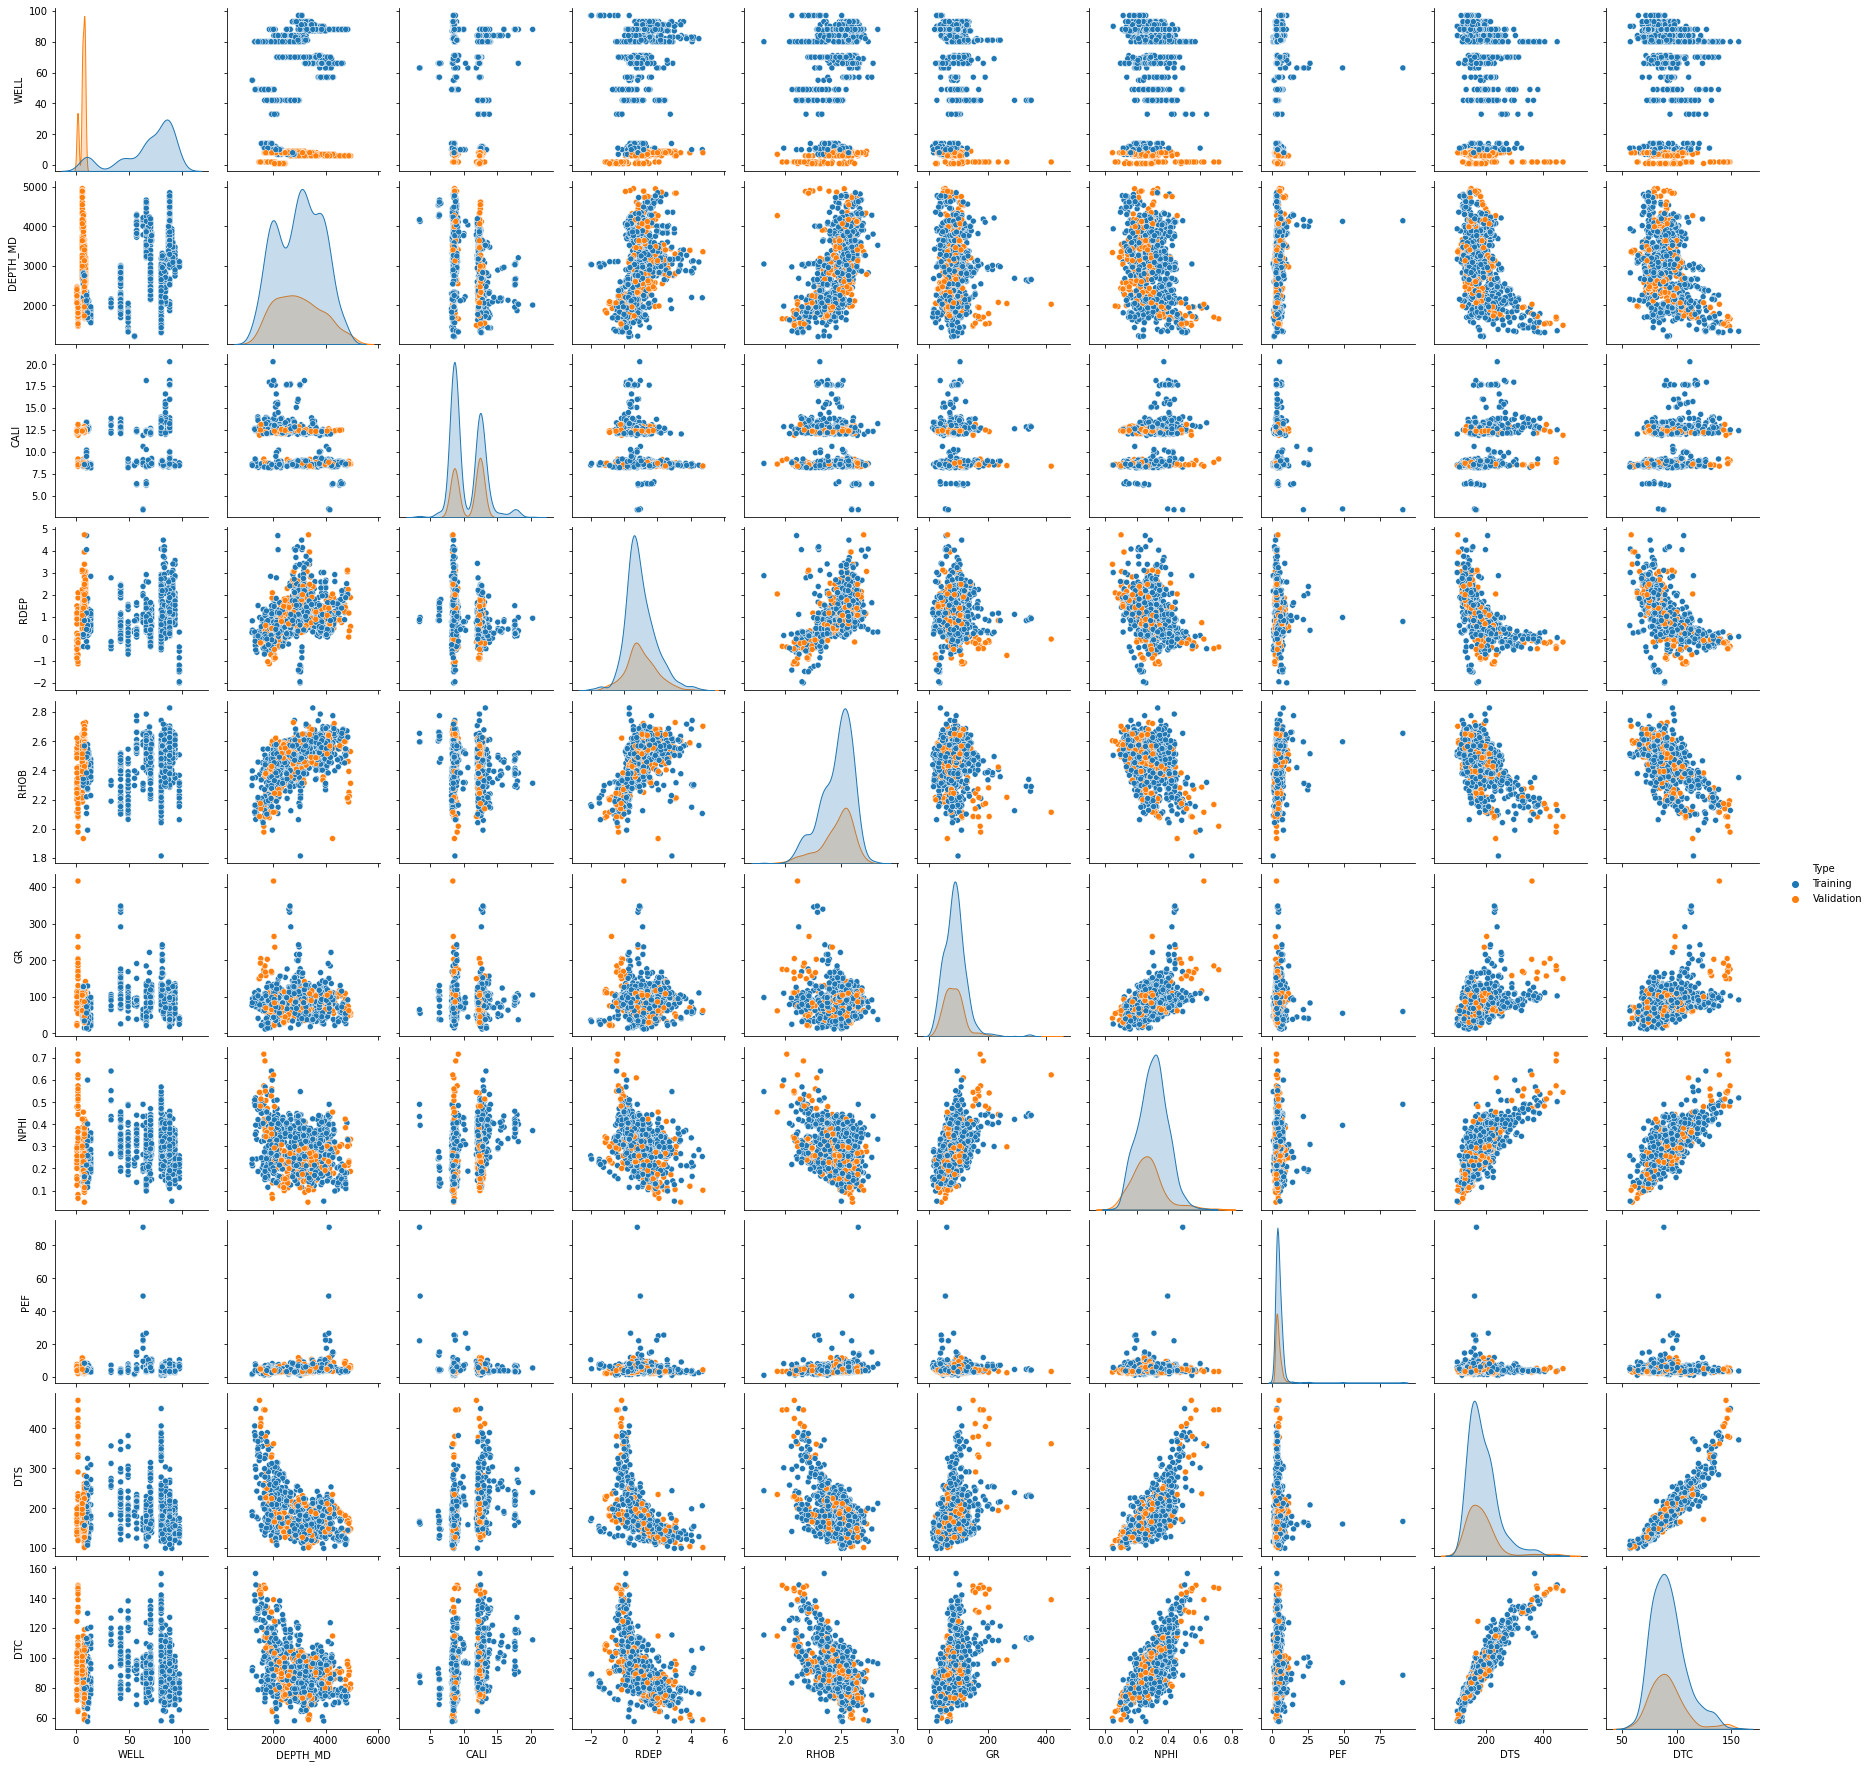

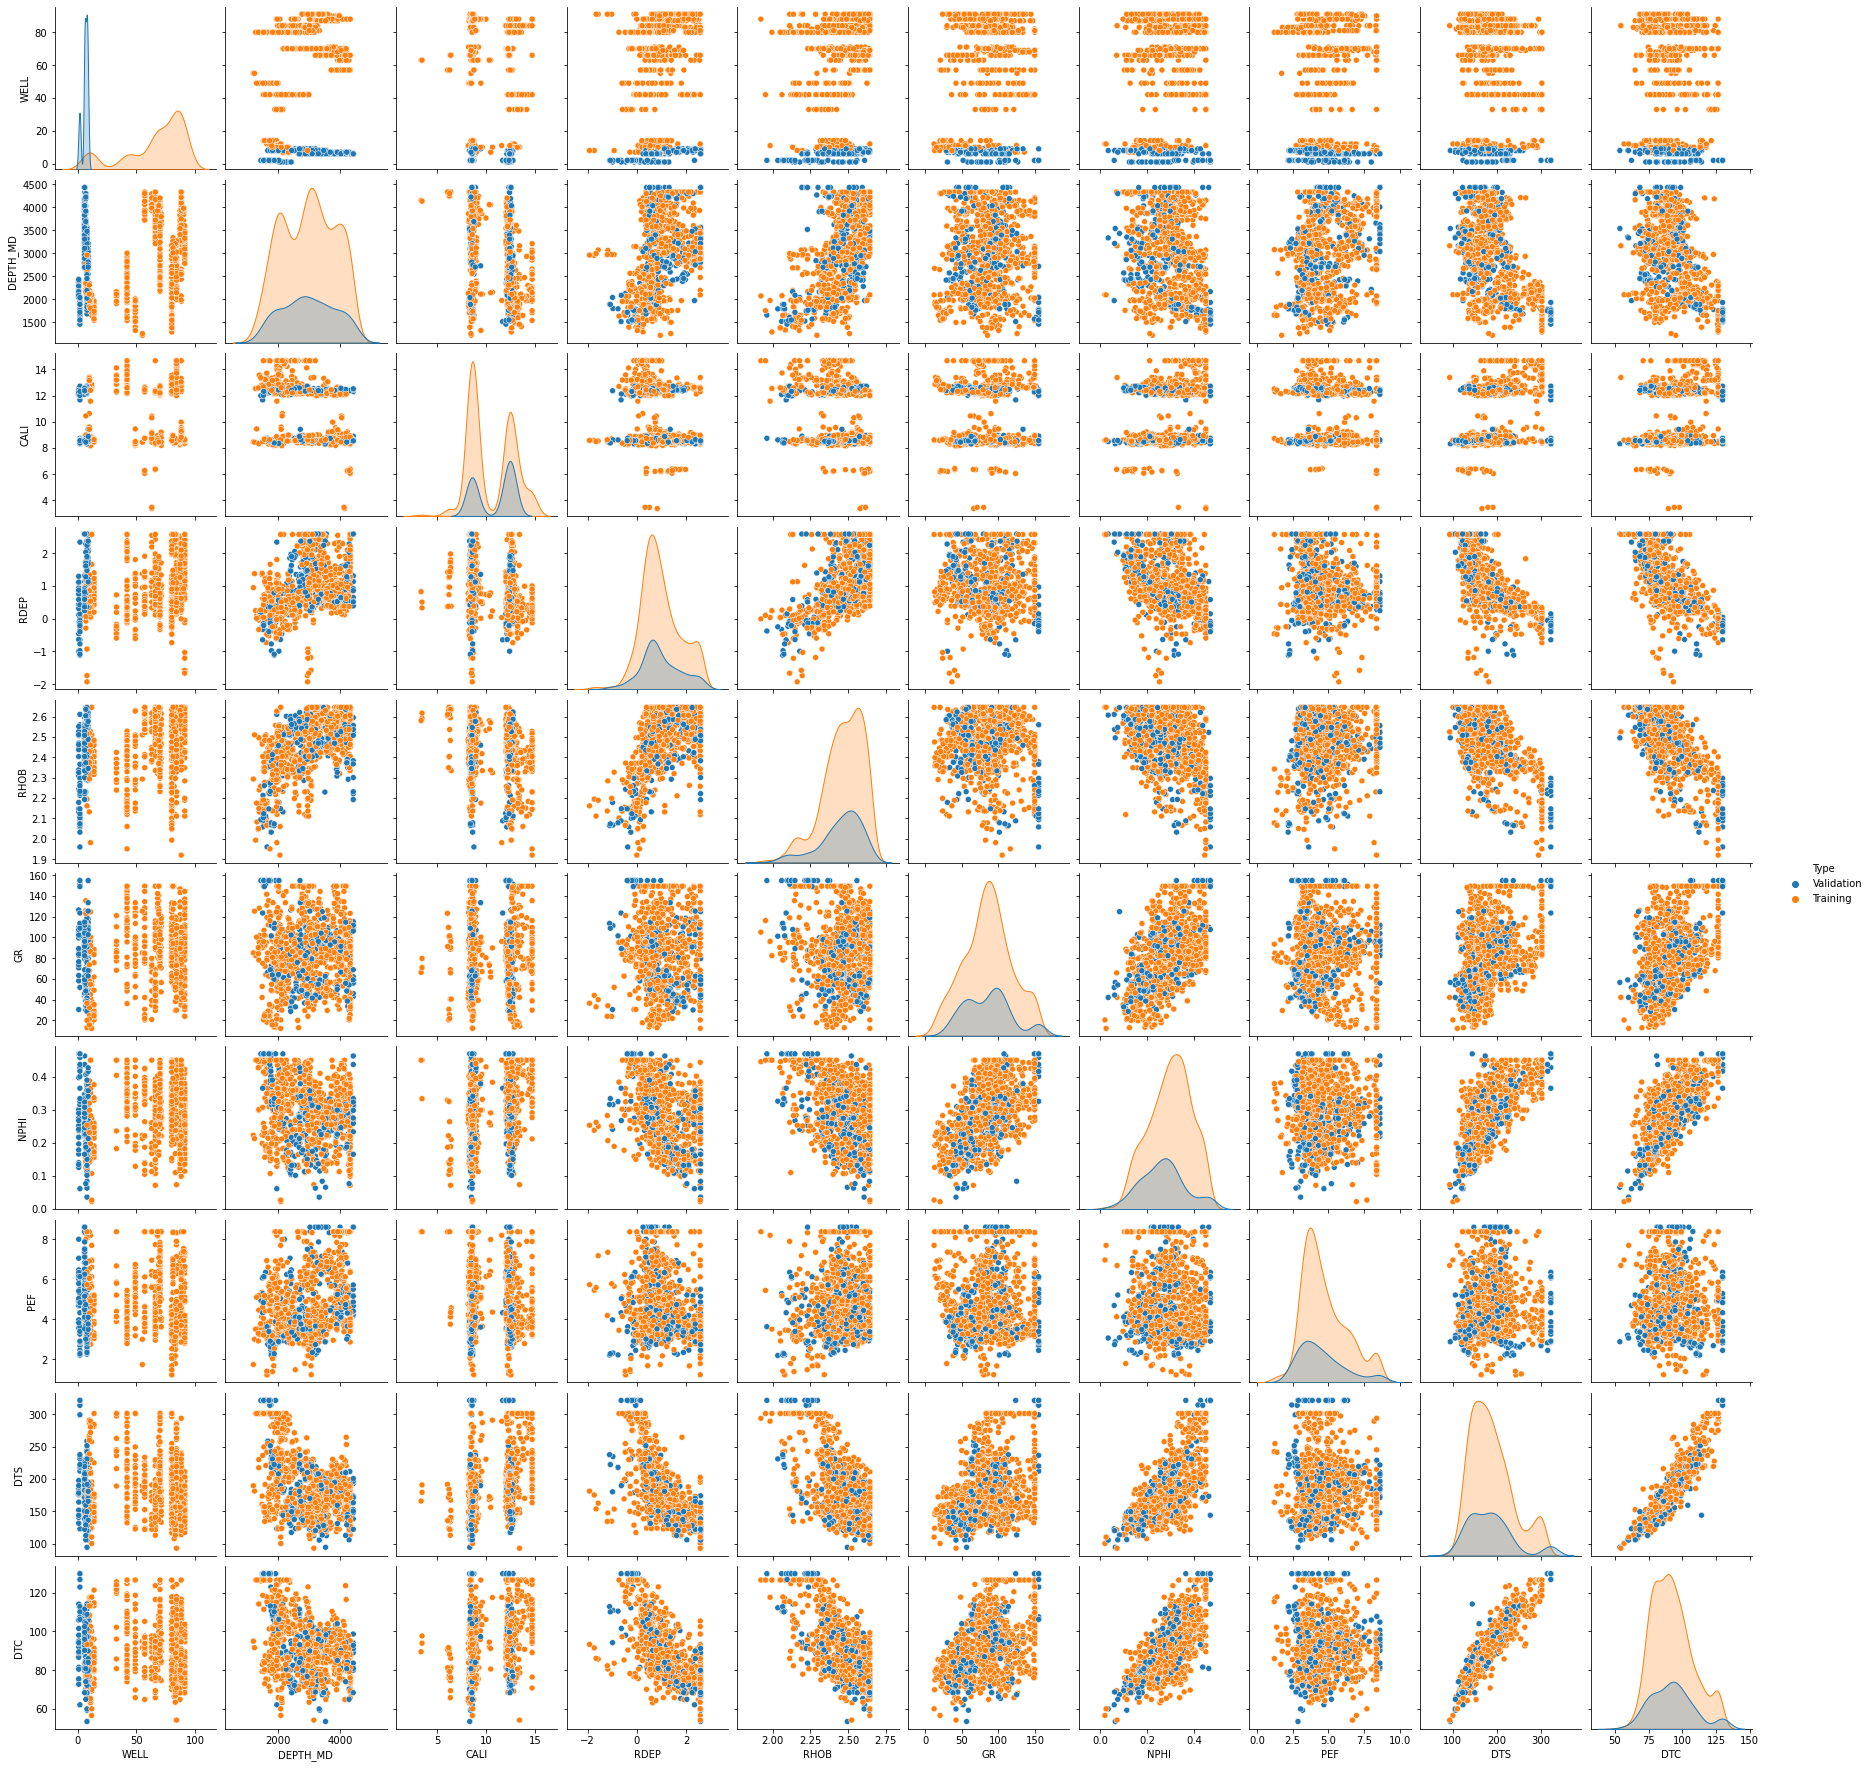

In [8]:
# Load the training data
train_data = pd.read_csv('../../../labs/data/train.csv', sep=';')
train_data['WELL'] = train_data['WELL'].astype('category').cat.codes

# Load the validing data
valid_data = pd.read_csv('../../../labs/data/leaderboard_test_features.csv', sep=';')
valid_data['WELL'] = valid_data['WELL'].astype('category').cat.codes

train_data = train_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']].copy().dropna()
valid_data = valid_data[~np.isnan(valid_data.DTS.values)][['WELL', 'DEPTH_MD','CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']].copy().dropna()

train_data['RDEP']=np.log(train_data.RDEP.values)
valid_data['RDEP']=np.log(valid_data.RDEP.values)

train_data['Type'] = 'Training'
valid_data['Type'] = 'Validation'

sns.pairplot(train_data.append(valid_data).sample(1024 , axis=0), hue='Type')

train_data = train_data.mask(train_data>train_data.quantile(0.95), train_data.quantile(0.95), axis=1)
valid_data = valid_data.mask(valid_data>valid_data.quantile(0.95), valid_data.quantile(0.95), axis=1)

sns.pairplot(train_data.append(valid_data).sample(1024 , axis=0), hue='Type')

transform = sklearn.preprocessing.MinMaxScaler()
df = train_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']]
train_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']] = pd.DataFrame(transform.fit_transform(df), columns=df.columns, index=df.index)

transform = sklearn.preprocessing.MinMaxScaler()
df = valid_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']]
valid_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']] = pd.DataFrame(transform.fit_transform(df), columns=df.columns, index=df.index)

# Select input
X_train = train_data[['CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC','WELL']].copy()
y_train = train_data[['DTS', 'WELL']].copy()

X_valid = valid_data[['CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC','WELL']].copy()
y_valid = valid_data[['DTS', 'WELL']].copy()

In [10]:
# Define Train Set
X_train = torch.from_numpy(X_train.to_numpy()).float().view(-1,X_train.shape[1])
y_train = torch.from_numpy(y_train.to_numpy()).float().view(-1,y_train.shape[1])
train_dataset = TensorDataset(X_train, y_train)

# Define Test Set
X_valid = torch.from_numpy(X_valid.to_numpy()).float().view(-1,X_valid.shape[1])
y_valid = torch.from_numpy(y_valid.to_numpy()).float().view(-1,y_valid.shape[1])
valid_dataset = TensorDataset(X_valid, y_valid)

# Wrap in PyTorch dataset
class WirelineDataset(torch.utils.data.Dataset):
    def __init__(self, data, seq_len, pred_type='DTS'):
        self.data = data
        self.seq_len = seq_len
        self.pred_type = pred_type
    def __getitem__(self, idx):

        well = np.unique(self.data.WELL.values[idx*self.seq_len:(idx+1)*self.seq_len])[0]
        if self.pred_type=='DTS':
            data = self.data.drop(columns=['DTS','Type']).values[idx*self.seq_len:(idx+1)*self.seq_len]
            label = self.data['DTS'].values[idx*self.seq_len:(idx+1)*self.seq_len].reshape(-1,1)
        elif self.pred_type=='FACIES':
            data = self.data.drop(columns=['FORCE_2020_LITHOFACIES_LITHOLOGY']).values[idx*self.seq_len:(idx+1)*self.seq_len]
            label = self.data['FORCE_2020_LITHOFACIES_LITHOLOGY'].values[idx*self.seq_len:(idx+1)*self.seq_len].reshape(-1,1)

        wells = {'well': well, 'data': data, 'label':label}

        return wells
    def __len__(self):
        return int(len(self.data)/self.seq_len)

In [11]:
# Naive way to segment the wireline data based on specific sequence length
seq_len = 512
df_train = train_data[train_data['WELL']==7][:seq_len]
for i in np.unique(train_data.WELL.values):
    sz = len(train_data[train_data['WELL']==i])//seq_len
    for j in range(sz):
        df_train_seq = train_data[train_data['WELL']==i][j*seq_len:(j+1)*seq_len]
        df_train = df_train.append(df_train_seq, ignore_index=True)
    
    df_train = df_train.append(train_data[train_data['WELL']==i][-seq_len:], ignore_index=True)

df_valid = valid_data[valid_data['WELL']==1][:seq_len]
for i in np.unique(valid_data.WELL.values):
    sz = len(valid_data[valid_data['WELL']==i])//seq_len
    for j in range(sz):
        df_valid_seq = valid_data[valid_data['WELL']==i][j*seq_len:(j+1)*seq_len]
        df_valid = df_valid.append(df_valid_seq, ignore_index=True)
    
    df_valid = df_valid.append(valid_data[valid_data['WELL']==i][-seq_len:], ignore_index=True)

# Removing less than sequence length well
for i in np.unique(train_data.WELL.values):
    if len(df_train[df_train.WELL==i])%seq_len!=0:
        print(i, len(train_data[train_data.WELL==55]))
        df_train = df_train.drop(df_train[df_train.WELL==i].index)

# Dataset
train_dataset = WirelineDataset(df_train, 512)
valid_dataset = WirelineDataset(df_valid, 512)

0.5714285714285714 0


In [12]:
df_train.drop(columns=['DTS','Type']).columns.values

array(['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF',
       'DTC'], dtype=object)

In [13]:
# Dataset
train_dataset = WirelineDataset(df_train, 128, pred_type='DTS')
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

## Data dari gua

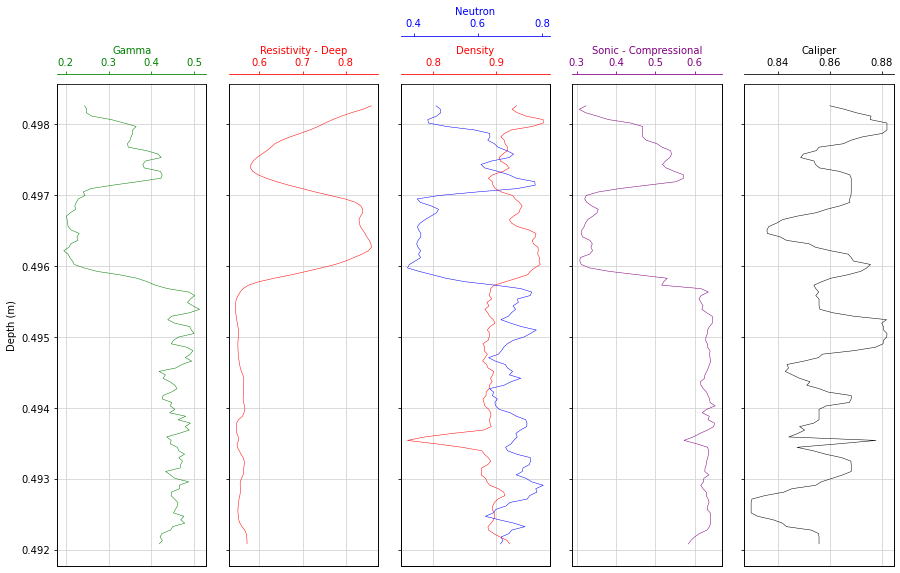

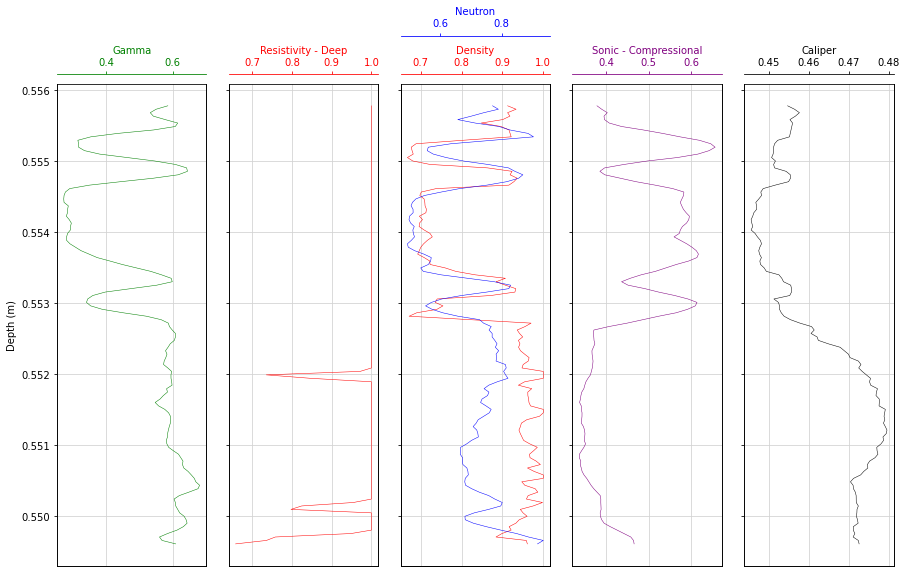

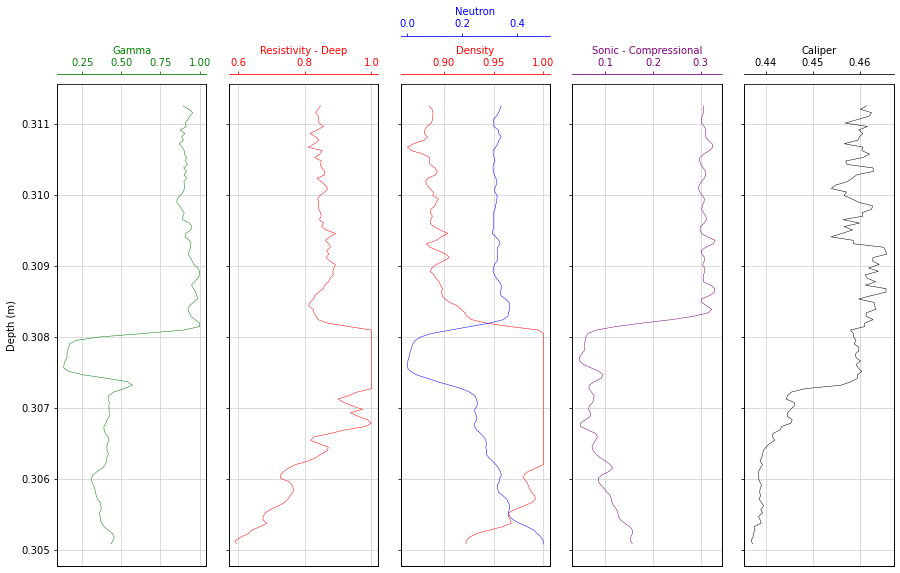

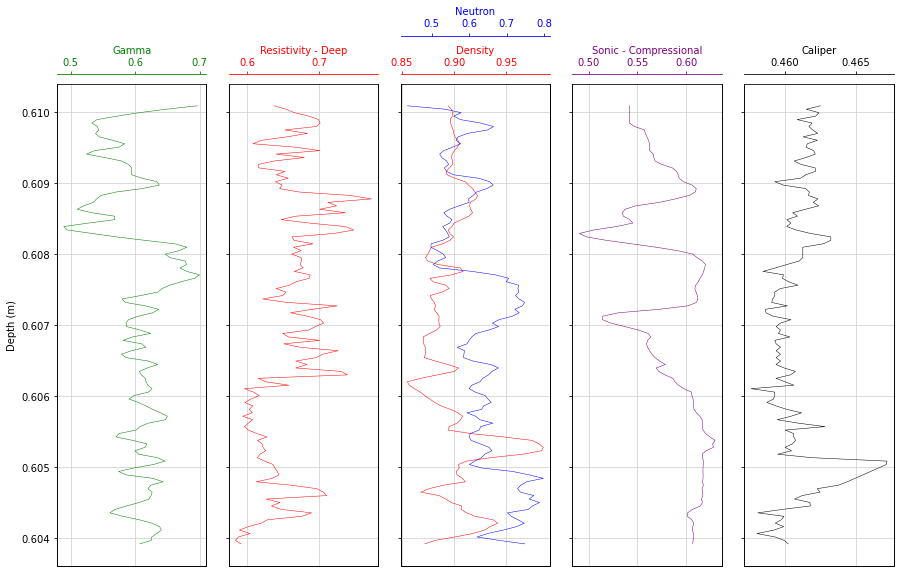

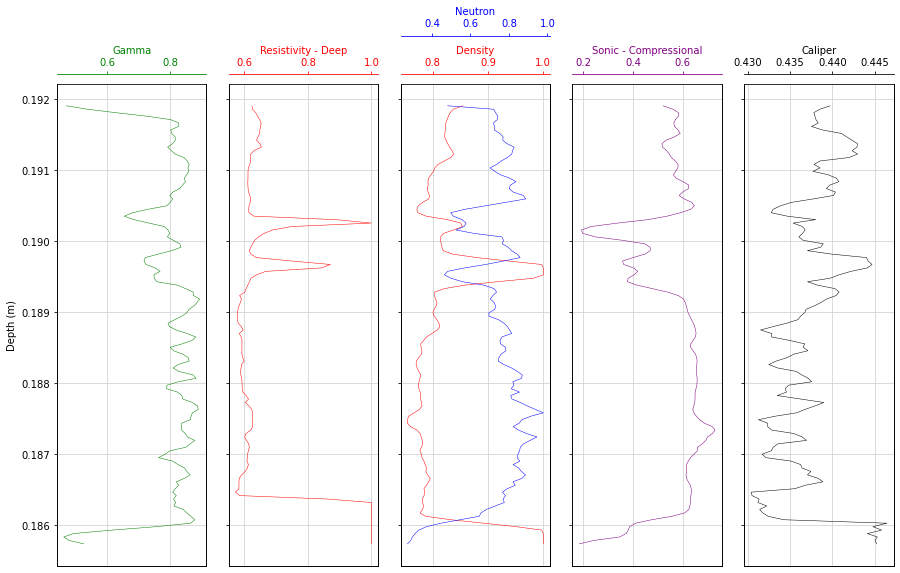

In [14]:
for i_batch, sample_batched in enumerate(train_loader):
    if i_batch % 250 == 0:
        df = pd.DataFrame(sample_batched['data'][0], columns=['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF','DTC'])
        plot_wirelines(df)